In [233]:
#!pip install keras_tuner --upgrade

   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ------ -------------------------------- 20.5/129.1 kB 640.0 kB/s eta 0:00:01
   --------------------- ----------------- 71.7/129.1 kB 975.2 kB/s eta 0:00:01
   ---------------------------------------- 129.1/129.1 kB 1.5 MB/s eta 0:00:00


In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
import keras_tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [5]:
data = pd.read_csv(r"C:\Users\brand\OneDrive\Documents\Bootcamp Projects\Capstone Project 2\Cleaned Data\cleaned_data")

In [7]:
# inspecting and choosing columns for model
print(data.columns)
data = data.drop(['Unnamed: 0','Name','Year_of_Release','Publisher','NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales','Developer'], axis=1)


Index(['Unnamed: 0', 'Name', 'Platform', 'Year_of_Release', 'Genre',
       'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales',
       'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score',
       'User_Count', 'Developer', 'Rating'],
      dtype='object')


In [9]:
data.head()

,Platform,Genre,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii,Sports,82.53,76,51,8.0,322,E
1,Wii,Racing,35.52,82,73,8.3,709,E
2,Wii,Sports,32.77,80,73,8.0,192,E
3,DS,Platform,29.80,89,65,8.5,431,E
4,Wii,Misc,28.92,58,41,6.6,129,E


In [15]:
#getting some basic descriptions of the data
print(data.describe())
print('-'*80)
print("Dataframe shape:\n",data.shape)
print('-'*80)
data.info()
print('-'*80)
print('Null value counts:\n',data.isnull().sum())
print('-'*80)


       Global_Sales  Critic_Score  Critic_Count   User_Score    User_Count
count   1688.000000   1688.000000   1688.000000  1688.000000   1688.000000
mean       1.898199     75.927725     42.361967     7.568246    325.350118
std        3.577727     11.476560     22.170379     1.132517    738.857794
min        0.040000     33.000000      4.000000     1.700000      4.000000
25%        0.410000     69.000000     25.000000     7.000000     36.000000
50%        0.910000     77.000000     40.000000     7.800000     87.000000
75%        2.040000     84.000000     57.250000     8.400000    263.000000
max       82.530000     98.000000    113.000000     9.600000  10179.000000
--------------------------------------------------------------------------------
Dataframe shape:
 (1688, 8)
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 8 columns):
 #   Column        Non-Null C

{'whiskers': [<matplotlib.lines.Line2D at 0x2640dee0cd0>,
 'caps': [<matplotlib.lines.Line2D at 0x2640dee2090>,
 'boxes': [<matplotlib.lines.Line2D at 0x2640dee0350>],
 'medians': [<matplotlib.lines.Line2D at 0x2640dee2f90>],
 'fliers': [<matplotlib.lines.Line2D at 0x2640dee37d0>],
 'means': []}

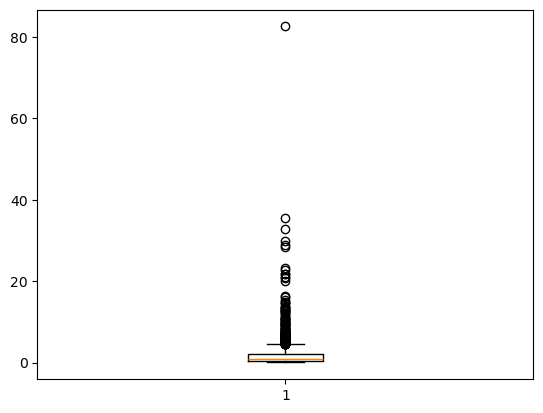

In [63]:
# Inspecting target value for predictions, lots of outliers
plt.boxplot(data['Global_Sales'])

Valid records left:
 (1270,)
filtered data descrption: 
 count    1270.000000
mean        1.068323
std         0.750900
min         0.210000
25%         0.470000
50%         0.850000
75%         1.490000
max         3.180000
Name: Global_Sales, dtype: float64


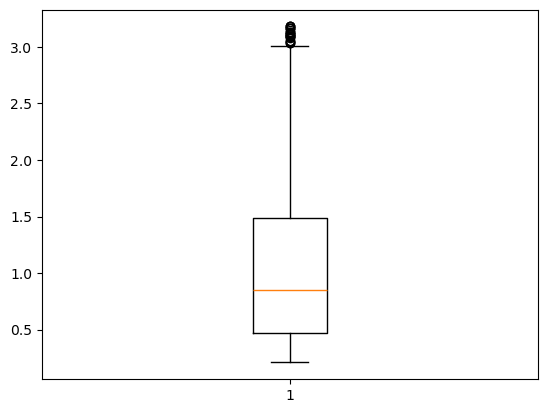

In [77]:
# filtering for lower 10% and  higher 85% quantiles of Global Sales. 
# Settled here because it left me enough data and filterd most of the extreme outliers.

l_quant = data['Global_Sales'].quantile(0.10)
h_quant = data['Global_Sales'].quantile(0.85)
data_filtered = data[(data['Global_Sales'] >= l_quant) & (data['Global_Sales'] <= h_quant)]

plt.boxplot(data_filtered['Global_Sales'])
print('Valid records left:\n',data_filtered['Global_Sales'].shape)
print("filtered data descrption: \n",data_filtered['Global_Sales'].describe())

In [250]:
# Label encoding
df = data_filtered
print(df.columns)
le = LabelEncoder()
df.loc[:,'Platform'] = le.fit_transform(df['Platform'])

df.loc[:,'Genre'] = le.fit_transform(df['Genre'])

df.loc[:,'Rating'] = le.fit_transform(df['Rating'])

Index(['Platform', 'Genre', 'Global_Sales', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'Rating'],
      dtype='object')


In [252]:
#setting target and features
X = df.drop('Global_Sales', axis=1)
y = df['Global_Sales']

#Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16, shuffle= False)

#Scaling data,choose min max my data does not follow a normal distribution.
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
#reshaping for LTSM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

#Verifying shape
print(X_train_scaled.shape,'\n', X_test_scaled.shape)

(889, 1, 7) 
 (381, 1, 7)


In [266]:
#building LTSM Model
model = Sequential()
model.add(LSTM(units=1000, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
#
model.add(Dense(32, activation='relu',))
model.add(Dropout(0.2))
model.add(Dense(16,activation='relu',))
model.add(Dropout(0.2))
model.add(Dense(1))
#compile
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae', 'mse'])

history = model.fit(X_train_scaled, y_train, epochs=128, batch_size=64, validation_data=(X_test_scaled, y_test))

Epoch 1/128
14/14 [==============================] - 2s 38ms/step - loss: 1.3836 - mae: 0.9387 - mse: 1.3836 - val_loss: 1.1963 - val_mae: 1.0621 - val_mse: 1.1963
Epoch 2/128
14/14 [==============================] - 0s 9ms/step - loss: 0.6652 - mae: 0.6566 - mse: 0.6652 - val_loss: 0.7109 - val_mae: 0.8179 - val_mse: 0.7109
Epoch 3/128
14/14 [==============================] - 0s 9ms/step - loss: 0.6093 - mae: 0.5981 - mse: 0.6093 - val_loss: 0.9719 - val_mae: 0.9610 - val_mse: 0.9719
Epoch 4/128
14/14 [==============================] - 0s 9ms/step - loss: 0.5468 - mae: 0.5801 - mse: 0.5468 - val_loss: 0.7718 - val_mae: 0.8545 - val_mse: 0.7718
Epoch 5/128
14/14 [==============================] - 0s 9ms/step - loss: 0.5719 - mae: 0.5771 - mse: 0.5719 - val_loss: 0.7390 - val_mae: 0.8331 - val_mse: 0.7390
Epoch 6/128
14/14 [==============================] - 0s 9ms/step - loss: 0.5394 - mae: 0.5813 - mse: 0.5394 - val_loss: 0.8434 - val_mae: 0.8874 - val_mse: 0.8434
Epoch 7/128
14/14 [==

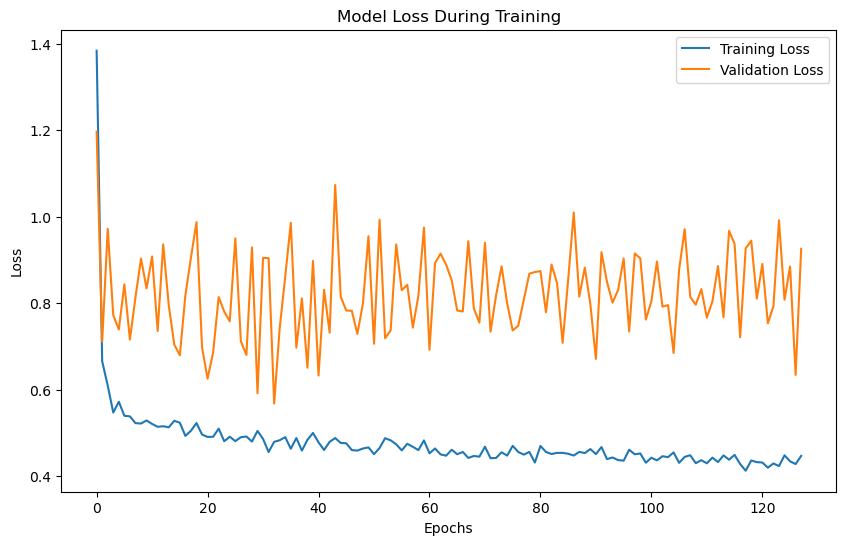

12/12 [==============================] - 0s 1ms/step - loss: 0.9256 - mae: 0.9264 - mse: 0.9256
Test Loss (MSE): 0.9256396293640137
Test Mean Absolute Error (MAE): 0.9264385104179382
Test Mean Squared Error (MSE): 0.9256396293640137


In [268]:
#Ploting Performance and taking evaluation metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss, mae, mse = model.evaluate(X_test_scaled, y_test)

print(f"Test Loss (MSE): {loss}")
print(f"Test Mean Absolute Error (MAE): {mae}")
print(f"Test Mean Squared Error (MSE): {mse}")

In [272]:
#Making predictions
y_pred = model.predict(X_test_scaled)
y_flat = y_pred.flatten()

12/12 [==============================] - 0s 1ms/step


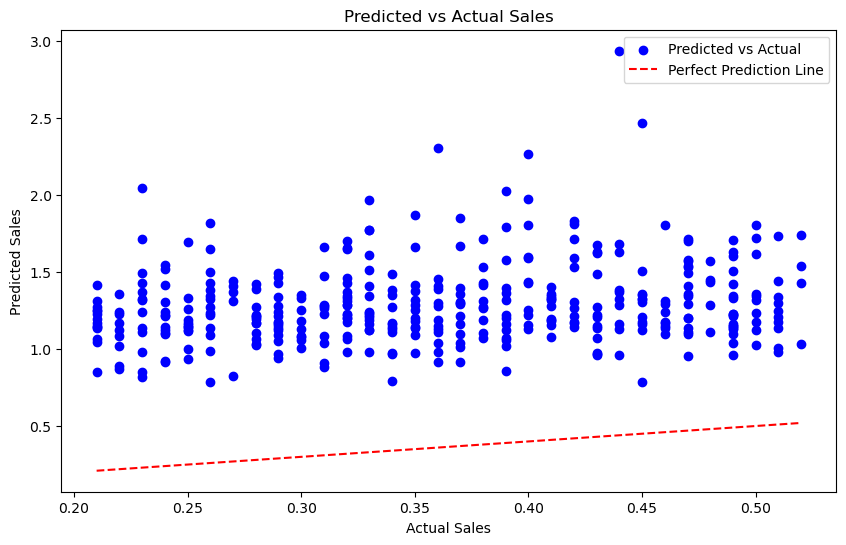

In [274]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.title('Predicted vs Actual Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.legend()
plt.show()

In [193]:
#save model
model.save('game_sales_predictions_model.keras')